In [89]:
import pandas as pd
import numpy as np
from collections import defaultdict
from operator import itemgetter
from IPython.display import display, IFrame

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
# from sklearn.utils import shuffle

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
# helpful functions

def showAll(status=True):
    if status:
        pd.set_option("display.max_rows", None)
    else:
        pd.set_option("display.max_rows", 10)

def sortListofTuples(tuples, reverse=False):
    return sorted(tuples, key=itemgetter(1), reverse=reverse)

def standardize(data, ddof=0):
    return (data - np.mean(data)) / np.std(data, ddof=ddof)

In [64]:
inspectCoefficients(olsMdl)

basis[T.2.0]: -0.14236882442746024
bond[T.2.0]: 0.27982499675437666
credit[T.3.0]: -0.11866039208156381
fmha_515[T.2.0]: 0.13908798561504293
non_prof[T.2.0]: 0.07989276804927799
rentassist[T.4.0]: 0.1318881827824077
type[T.2.0]: -0.12201451574912078
li_units: 0.2194360277685597
tcep_amt: 0.02887567623319949


In [70]:
dataDict = {
    'trgt_fam': 'trgt_fam - targets a specific pop - families (1 - yes, 2 - no)',
    'trgt_eld': 'trgt_eld - targets a specific pop - elderly (1 - yes, 2 - no)',
    'non_prof': 'non_prof - non-profit sponsor (1 - yes, 2 - no)',
    'qct': 'qct - is in qualified census tract? (1 - yes, 2 - no)',
    'type': 'type - construction type (1 - new const, 2 - acq & rehab, 3 - both new constr and A/R, 4 - existing)',
    'basis': 'basis - increase in eligible basis (1 - yes, 2 - no)',
    'bond': 'bond - tax-excempt bond received (1 - yes, 2 - no)',
    'credit': 'credit - type of credit percentage (1 - 30% of PV, 2 - 70% of PV, 3 - both, 4 - TCEP only)',
    'fmha_515': 'fmha_515 - FmHA (RHS) section 515 loan (rural rental housing loan) (1 - yes, 2 - no)',
    'rentassist': 'rentassist - fed or state project-based rental assistance contract (1 - federal, 2 - state, 3 - both, 4 - neither, 5 - unknown)',
    'li_units': 'li_units - total # of low income units as reported by HFA',
    'tcep_amt': 'tcep_amt - tax credit exchange prog funds amount'
}

In [3]:
# For record keeping

# phys attrs: ['inc_ceil', 'low_ceil', 'non_prof', 'basis', 'bond', 'mff_ra',
#        'fmha_515', 'fmha_538', 'home', 'cdbg', 'hopevi', 'tcep', 'rentassist',
#        'trgt_pop', 'trgt_fam', 'trgt_eld', 'trgt_dis', 'trgt_hml',
#        'trgt_other', 'type', 'credit', 'metro', 'dda', 'qct', 'allocamt']

In [44]:
df = pd.read_csv('C:/Users/phuro/UCSD/ULI/H2H/ULI-UCSD_H2H/LIHTC_analysis/data/cleanLIHTC.csv', index_col=0)

In [45]:
((df.isna().sum() / df.shape[0])*100)[(df.isna().sum() / df.shape[0])*100 > 65]

ceilunit      68.836887
mff_ra        69.038783
trgt_dis      65.308516
trgt_hml      70.386679
trgt_other    68.236968
dda           65.958429
dtype: float64

In [46]:
nonPhysCols = ['scatter_site_cd', 'allocamt', 'n_units', 'li_units', 'n_0br', \
    'n_1br', 'n_2br', 'n_3br', 'n_4br', 'yr_alloc', 'non_prof', 'basis', 'bond',
    'fmha_515', 'home', 'home_amt', 'tcap_amt', 'fha', 'hopevi', 'hpvi_amt', 
    'tcep', 'tcep_amt', 'rentassist', 'type', 'credit', 'n_unitsr', 'li_unitr']

In [47]:
df.drop(columns=[col for col in df.columns if col not in nonPhysCols], inplace=True)

In [48]:
df.dropna(inplace=True)

In [49]:
df

,allocamt,n_units,li_units,n_0br,n_1br,n_2br,n_3br,n_4br,yr_alloc,non_prof,basis,bond,fmha_515,home,home_amt,tcap_amt,fha,hopevi,hpvi_amt,tcep,tcep_amt,rentassist,type,credit,n_unitsr,li_unitr
104,938911.0,56.0,28.0,0.0,12.0,40.0,4.0,0.0,2012.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,56.0,28.0
106,282802.0,24.0,24.0,0.0,8.0,8.0,8.0,0.0,2012.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,24.0,24.0
107,1441310.0,66.0,33.0,0.0,0.0,20.0,46.0,0.0,2012.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,2.0,66.0,33.0
109,430150.0,55.0,55.0,0.0,55.0,0.0,0.0,0.0,2013.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,55.0,55.0
110,1006008.0,56.0,40.0,1.0,39.0,16.0,0.0,0.0,2013.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,2.0,56.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50044,305794.0,38.0,38.0,0.0,0.0,24.0,12.0,2.0,2014.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,1.0,38.0,38.0
50081,0.0,166.0,164.0,0.0,34.0,82.0,50.0,0.0,2015.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,1.0,166.0,164.0
51983,218178.0,28.0,27.0,0.0,10.0,18.0,0.0,0.0,2014.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,28.0,27.0
51984,222333.0,12.0,12.0,0.0,0.0,4.0,8.0,0.0,2014.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,3.0,12.0,12.0


In [50]:
bedPercentages = defaultdict(list)
def getBedPercentages(row):
    total = row['n_0br'] + row['n_1br'] + row['n_2br'] + row['n_3br'] + row['n_4br']
    for i in range(5):
        bedPercentages[f'n_{i}br'].append(np.round(row[f'n_{i}br'] / total, 2))

df.apply(getBedPercentages, axis=1)

for key, item in bedPercentages.items():
    df[f'per_{key[2:]}'] = item

In [51]:
df.drop(columns=[col for col in df.columns if col in ['n_0br', 'n_1br', 'n_2br',\
     'n_3br', 'n_4br', 'n_unitsr', 'li_unitr']], inplace=True)

In [52]:
df

,allocamt,n_units,li_units,yr_alloc,non_prof,basis,bond,fmha_515,home,home_amt,tcap_amt,fha,hopevi,hpvi_amt,tcep,tcep_amt,rentassist,type,credit,per_0br,per_1br,per_2br,per_3br,per_4br
104,938911.0,56.0,28.0,2012.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,0.00,0.21,0.71,0.07,0.00
106,282802.0,24.0,24.0,2012.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,0.00,0.33,0.33,0.33,0.00
107,1441310.0,66.0,33.0,2012.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,2.0,0.00,0.00,0.30,0.70,0.00
109,430150.0,55.0,55.0,2013.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,0.00,1.00,0.00,0.00,0.00
110,1006008.0,56.0,40.0,2013.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,2.0,0.02,0.70,0.29,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50044,305794.0,38.0,38.0,2014.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,1.0,0.00,0.00,0.63,0.32,0.05
50081,0.0,166.0,164.0,2015.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,1.0,0.00,0.20,0.49,0.30,0.00
51983,218178.0,28.0,27.0,2014.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,3.0,0.00,0.36,0.64,0.00,0.00
51984,222333.0,12.0,12.0,2014.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,1.0,3.0,0.00,0.00,0.33,0.67,0.00


In [53]:
df.columns

Index(['allocamt', 'n_units', 'li_units', 'yr_alloc', 'non_prof', 'basis',
       'bond', 'fmha_515', 'home', 'home_amt', 'tcap_amt', 'fha', 'hopevi',
       'hpvi_amt', 'tcep', 'tcep_amt', 'rentassist', 'type', 'credit',
       'per_0br', 'per_1br', 'per_2br', 'per_3br', 'per_4br'],
      dtype='object')

In [54]:
cateCols = ['non_prof', 'basis', 'bond', 'fmha_515', 'home', 'fha', 'hopevi', \
    'tcep', 'rentassist', 'type', 'credit', 'yr_alloc']
standardizeCols = ['allocamt', 'n_units', 'li_units', 'home_amt', 'tcap_amt', \
    'hpvi_amt', 'tcep_amt']

for col in cateCols:
    df[col] = df[col].astype('category')

for col in standardizeCols:
    df[col] = standardize(df[col])

In [55]:
df.dtypes

allocamt       float64
n_units        float64
li_units       float64
yr_alloc      category
non_prof      category
basis         category
bond          category
fmha_515      category
home          category
home_amt       float64
tcap_amt       float64
fha           category
hopevi        category
hpvi_amt       float64
tcep          category
tcep_amt       float64
rentassist    category
type          category
credit        category
per_0br        float64
per_1br        float64
per_2br        float64
per_3br        float64
per_4br        float64
dtype: object

In [56]:
df.head(2)

,allocamt,n_units,li_units,yr_alloc,non_prof,basis,bond,fmha_515,home,home_amt,tcap_amt,fha,hopevi,hpvi_amt,tcep,tcep_amt,rentassist,type,credit,per_0br,per_1br,per_2br,per_3br,per_4br
104,0.338280,-0.109177,-0.501131,2012.0,2.0,1.0,2.0,1.0,2.0,-0.280626,-0.095225,2.0,2.0,-0.030223,2.0,-0.070157,4.0,2.0,3.0,0.0,0.21,0.71,0.07,0.0
106,-0.158817,-0.567256,-0.563132,2012.0,2.0,2.0,2.0,2.0,2.0,-0.280626,-0.095225,2.0,2.0,-0.030223,2.0,-0.070157,4.0,2.0,3.0,0.0,0.33,0.33,0.33,0.0


In [58]:
def ols(df, target):

    """
    Function performing ordinary least square regression on df 

    """

    formula = f'{target} ~ ' + ' + '.join(df.columns.difference([target]))
    print(formula)
    mdl = smf.ols(formula, data=df).fit()
    print(mdl.summary())
    
    return mdl

In [59]:
olsMdl = ols(df, 'allocamt')

allocamt ~ basis + bond + credit + fha + fmha_515 + home + home_amt + hopevi + hpvi_amt + li_units + n_units + non_prof + per_0br + per_1br + per_2br + per_3br + per_4br + rentassist + tcap_amt + tcep + tcep_amt + type + yr_alloc
                            OLS Regression Results                            
Dep. Variable:               allocamt   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     10.68
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.67e-93
Time:                        14:36:06   Log-Likelihood:                -7312.2
No. Observations:                5444   AIC:                         1.475e+04
Df Residuals:                    5382   BIC:                         1.516e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                      

In [77]:
def inspectCoefficients(model):

    """
    Identify and print weights of attributes with pvalue < 0.05
    
    """

    sig = model.pvalues[model.pvalues < 0.05].index.to_list()
    for attr in sig:
        print(dataDict[attr.split('[')[0]])
        print(f"{attr}: {model.params[attr]}")
        print()

    return sig

In [78]:
sigOls = inspectCoefficients(olsMdl)

basis - increase in eligible basis (1 - yes, 2 - no)
basis[T.2.0]: -0.14236882442746024

bond - tax-excempt bond received (1 - yes, 2 - no)
bond[T.2.0]: 0.27982499675437666

credit - type of credit percentage (1 - 30% of PV, 2 - 70% of PV, 3 - both, 4 - TCEP only)
credit[T.3.0]: -0.11866039208156381

fmha_515 - FmHA (RHS) section 515 loan (rural rental housing loan) (1 - yes, 2 - no)
fmha_515[T.2.0]: 0.13908798561504293

non_prof - non-profit sponsor (1 - yes, 2 - no)
non_prof[T.2.0]: 0.07989276804927799

rentassist - fed or state project-based rental assistance contract (1 - federal, 2 - state, 3 - both, 4 - neither, 5 - unknown)
rentassist[T.4.0]: 0.1318881827824077

type - construction type (1 - new const, 2 - acq & rehab, 3 - both new constr and A/R, 4 - existing)
type[T.2.0]: -0.12201451574912078

li_units - total # of low income units as reported by HFA
li_units: 0.2194360277685597

tcep_amt - tax credit exchange prog funds amount
tcep_amt: 0.02887567623319949



In [83]:
def KMeansClustering(df, \
                     n_clusters, 
                     show_steps,
                     *argv):

    # initiate and fit model
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df)

    # get cluster labels
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    if show_steps:
        print("Cluster Labels:", cluster_labels)
        print("Cluster Centers:", cluster_centers)

    # plot
    df['cluster'] = cluster_labels 
    fig = px.scatter_3d(
        data_frame=df,
        x=argv[0],
        y=argv[1],
        z=argv[2],
        color='cluster'
    )
    
    fig.update_layout(
        scene = dict(
            xaxis_title=argv[0],
            yaxis_title=argv[1],
            zaxis_title=argv[2]
            ),
            margin=dict(l=0, r=0, b=0, t=0)
    )

    # return fig
    fig.show()

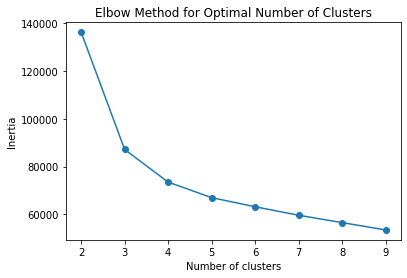

In [93]:
# Determine optimal number of clusters 

data = df.dropna()
inertias = []

# Define range of clusters to try
clusters_range = range(2, 10)

# Calculate inertia for each cluster
for k in clusters_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(clusters_range, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

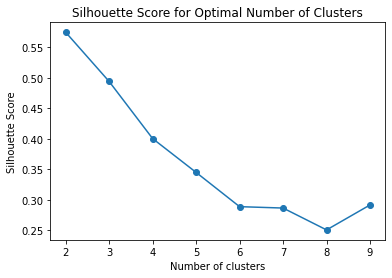

In [94]:
silhouette_scores = []

# Define range of clusters to try
clusters_range = range(2, 10)

# Calculate silhouette score for each cluster
for k in clusters_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    silhouette_scores.append(silhouette_score(data, kmeans.labels_))

# Plot the silhouette scores
plt.plot(clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

In [95]:
for attr in sigOls:
    var = attr.split('[')[0]
    KMeansClustering(df[df['allocamt'] < 11].dropna(), 6, False, var, 'per_1br', 'allocamt')